In [1]:
import numpy as np
import torch
from pyro import distributions as dist
from pyro.poutine import trace, uncondition
from torch.distributions import constraints
import pyro.optim
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.infer import NUTS,MCMC
import matplotlib.pyplot as plt
import pdb
import sys
sys.path.append("../..")
from models_and_guides import *
from initializations import *

In [2]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [3]:
def piecewise_eval(knot_x, knot_y, x):
    # I haven't unit tested this:
    n_knots = knot_x.size(-1)
    assert n_knots >= 2
    knot_x, idx = knot_x.sort(dim=-1)
    knot_y = knot_y.gather(-1,idx)
    lb = (x.unsqueeze(-1) > knot_x[...,1:].unsqueeze(-2)).long().sum(-1)
    lb[lb >= n_knots - 1] = n_knots - 2
    ub = lb + 1
    x0 = knot_x.gather(-1,lb)
    x1 = knot_x.gather(-1,ub)
    y0 = knot_y.gather(-1,lb)
    y1 = knot_y.gather(-1,ub)
    #slopes = (y1-y0)/(x1-x0)
    slopes = (y1-y0)/(x1-x0).clamp(min=1e-8)
    return slopes*x + (y1 - slopes*x1)
    
#def piecewise_regression(x, y, n_pieces=3):
#    knot_x = pyro.sample("knot_x",
#                         dist.Uniform(0, 100)
#                             .expand([n_pieces]).to_event(0))
#    knot_y = pyro.sample("knot_y",
#                         dist.Normal(0, 100)
#                             .expand([n_pieces]).to_event(0))
#    y_pred = piecewise_eval(knot_x, knot_y, x)
#    y_scale = pyro.sample("y_scale", dist.LogNormal(0, 1))
#    y = pyro.sample("obs", dist.Normal(y_pred, y_scale),
#                obs=y)
#    return y

def piecewise_regression(x, y, n_pieces=3):
    knot_x = pyro.sample("knot_x",
                         dist.Uniform(0, 1)
                             .expand([n_pieces]).to_event(0))
    knot_y = pyro.sample("knot_y",
                         dist.Normal(0, 1)
                             .expand([n_pieces]).to_event(0))
    x_len = x.shape[0]
    y_pred = piecewise_eval(x_len*knot_x, x_len*knot_y, x)
    y_scale = pyro.sample("y_scale", dist.LogNormal(0, 1))
    y = pyro.sample("obs", dist.Normal(y_pred, y_scale),
                obs=y)
    return y

In [4]:
N = 100
x = torch.arange(N)
n_pieces = 5
dgp_trace = trace(uncondition(piecewise_regression)).get_trace(x,x,n_pieces)

In [5]:
dgp_vars = {name:dgp_trace.nodes[name]['value'] for name in dgp_trace.reparameterized_nodes}

In [6]:
y = dgp_vars['obs']

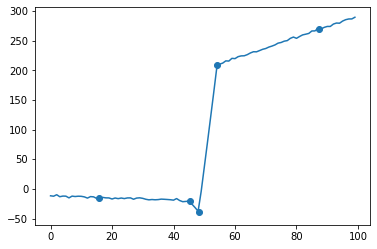

In [7]:
plt.plot(x,y)
plt.scatter(N*dgp_vars['knot_x'],N*dgp_vars['knot_y'])

In [8]:
from pyro.infer.autoguide.initialization import init_to_sample

In [9]:
guide = AutoDiagonalNormal(piecewise_regression,init_loc_fn=init_to_sample)

In [10]:
pyro.clear_param_store()

In [11]:
optim = pyro.optim.Adam({"lr": 0.06})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, guide, optim, loss=elbo)

In [12]:
losses = []
guide(x,y,n_pieces)
param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
gradient_norms = defaultdict(list)
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

for i in range(10000):
    losses.append(svi.step(x,y,n_pieces))
    param_history = {k:torch.cat([param_history[k],v.unsqueeze(0).detach()],dim=0) for k,v in pyro.get_param_store().items()}

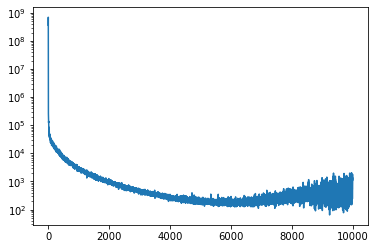

In [13]:
plt.plot(list(gradient_norms.values())[0])
plt.yscale('log')

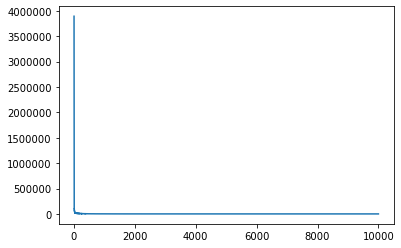

In [14]:
plt.plot(losses)

In [15]:
param_history

{'AutoDiagonalNormal.loc': tensor([[ 1.2087, -0.9203, -0.6803,  ..., -0.0426,  1.1307,  0.9878],
         [ 1.2087, -0.9203, -0.6803,  ..., -0.0426,  1.1307,  0.9878],
         [ 1.1558, -0.9785, -0.6222,  ...,  0.0157,  1.1311,  1.0460],
         ...,
         [ 0.1801, -1.3535, -0.0609,  ...,  2.8059,  2.1204,  1.9599],
         [ 0.1950, -1.3535, -0.0609,  ...,  2.8063,  2.1265,  1.9598],
         [ 0.1906, -1.3535, -0.0609,  ...,  2.8126,  2.1297,  1.9598]],
        grad_fn=<CatBackward>),
 'AutoDiagonalNormal.scale': tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
         [0.0942, 0.1062, 0.0942,  ..., 0.1062, 0.1062, 0.1062],
         [0.0905, 0.1018, 0.0894,  ..., 0.1081, 0.1067, 0.1113],
         ...,
         [0.0044, 0.0780, 0.0408,  ..., 0.0163, 0.0202, 0.0902],
         [0.0044, 0.0780, 0.0408,  ..., 0.0163, 0.0204, 0.0901],
         [0.0045, 0.0780, 0.0408,  ..., 0.0162, 0.0206, 0.0901]],
        grad_fn=<CatBackward>)}

In [16]:
param_history['AutoDiagonalNormal.loc'][-1]

tensor([ 0.1906, -1.3535, -0.0609,  2.7271,  0.1883,  1.9862, -0.1567, -0.2279,
         2.8126,  2.1297,  1.9598], grad_fn=<SelectBackward>)

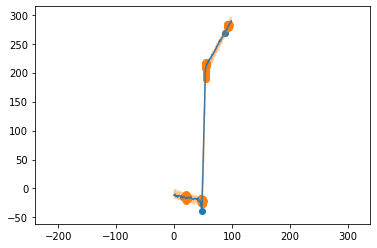

In [20]:
#pred = pyro.infer.predictive.Predictive(uncondition(piecewise_regression),guide=guide,num_samples=10)
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=guide,num_samples=100)

fit = pred(x,y,n_pieces)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

%matplotlib inline
plt.plot(x,y)
plt.scatter(N*dgp_vars['knot_x'],N*dgp_vars['knot_y'])
plt.errorbar(x,fit_obs_mean,yerr=fit_obs_std,alpha=.2)
plt.scatter(N*fit['knot_x'].detach().numpy(),N*fit['knot_y'].detach().numpy())
plt.axis('equal');
#plt.plot(x,slope_fit*x.numpy()+intercept_fit)
#plt.plot(x,fit_obs)

In [18]:
dgp_vars

{'knot_x': tensor([0.4527, 0.8747, 0.5421, 0.4818, 0.1565]),
 'knot_y': tensor([-0.1980,  2.6921,  2.0942, -0.3898, -0.1479]),
 'y_scale': tensor(1.1730),
 'obs': tensor([-11.7124, -12.3975,  -9.8923, -13.2659, -12.1861, -12.3258, -15.2271,
         -12.2416, -12.9330, -12.4060, -12.5834, -13.5304, -15.5816, -13.0654,
         -13.4857, -16.1616, -15.8941, -14.4335, -15.1976, -15.2923, -17.1095,
         -15.4388, -16.4905, -15.4705, -16.4189, -15.3075, -15.2435, -17.5102,
         -15.5415, -15.1166, -16.0291, -17.5753, -18.5291, -17.9944, -18.4296,
         -18.1210, -17.3153, -17.5919, -17.9441, -18.3558, -19.0449, -16.3671,
         -19.6831, -21.6435, -21.1866, -20.6655, -25.8151, -31.5016, -37.7220,
          -4.1882,  36.2140,  76.6807, 117.9463, 159.1740, 201.3306, 210.2868,
         212.0417, 215.7683, 215.4992, 220.0530, 219.5965, 222.8710, 224.1850,
         224.3754, 226.3019, 229.1199, 231.1954, 231.0630, 233.1791, 235.3163,
         236.6416, 239.0475, 240.6949, 242.6928,

In [19]:
fit

{'knot_x': tensor([[0.5489, 0.1998, 0.4706, 0.9295, 0.5470],
         [0.5458, 0.1838, 0.4992, 0.9413, 0.5500],
         [0.5459, 0.1986, 0.4980, 0.9502, 0.5406],
         [0.5467, 0.2235, 0.4839, 0.9374, 0.5454],
         [0.5474, 0.2012, 0.5003, 0.9287, 0.5541],
         [0.5473, 0.2095, 0.4842, 0.9420, 0.5521],
         [0.5453, 0.2170, 0.4804, 0.9240, 0.5472],
         [0.5490, 0.1982, 0.4827, 0.9496, 0.5490],
         [0.5475, 0.2326, 0.4971, 0.9333, 0.5518],
         [0.5463, 0.2027, 0.4758, 0.9386, 0.5436],
         [0.5485, 0.1817, 0.4789, 0.9558, 0.5375],
         [0.5470, 0.2144, 0.4834, 0.9420, 0.5716],
         [0.5483, 0.2025, 0.4736, 0.9364, 0.5546],
         [0.5484, 0.1874, 0.4945, 0.9268, 0.5545],
         [0.5478, 0.1980, 0.4805, 0.9356, 0.5481],
         [0.5480, 0.1956, 0.4874, 0.9276, 0.5523],
         [0.5480, 0.1950, 0.4706, 0.9225, 0.5555],
         [0.5460, 0.2280, 0.4889, 0.9259, 0.5424],
         [0.5463, 0.2178, 0.4981, 0.9303, 0.5545],
         [0.5488, 0.1